##### This notebook demonstrates how to combine satellite imagery and species occurrence data to explore vegetation patterns across a region of interest (ROI)/area of interest (AOI) in South Africa. We use Google Earth Engine (GEE) to access and analyze Landsat 8 Collection 2 Level 2 imagery (LANDSAT/LC08/C02/T1_L2), focusing on the Normalized Difference Vegetation Index (NDVI) as a proxy for vegetation health.

We then integrate this Earth observation data with biodiversity records from the Global Biodiversity Information Facility (GBIF). Specifically, we:

1. Define an ROI in South Africa using GEE.

2. Calculate NDVI from Landsat 8 imagery over this region.

3. Download GBIF occurrence records for multiple species within the ROI.

4. Overlay species records on NDVI imagery to visualize spatial patterns.

5. Extract NDVI values at each species observation point and compile results into a CSV file.

Perform statistical analysis, including:

1. A boxplot showing the distribution of NDVI values for each species.

2. Unsupervised clustering (KMeans) of species based on their mean NDVI to reveal ecological groupings.

3. A pivot table summarizing mean NDVI, standard deviation, and number of occurrences per species.

This workflow showcases how open-access remote sensing and biodiversity data can be integrated for ecological insight, monitoring habitat preferences, and characterizing species-environment relationships.

#### Import Earth Engine and GEEMap so you can authenticate and initialize your project. If you have never authenticated before, you will be asked to enter your username and password

In [1]:
import ee
import geemap

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project="ee-krle4401")

#### Now that is square away, let's pull some satellite at some satellite data that happened during the BioSCape Campaign (2023-10-22 to 2023-11-26). We are going to be visualizing the data directly in our Jupyter notebook.

##### Note: If you are getting seemingly blank or white tiles when you pull in imagery, you may need to perform a strech.

1. Click the gear icon on your layer
2. Click the dropdown menu beside the "Stretch" option
3. Select 100% in the dropdown menu
4. Click "Apply"

In [47]:
# Create ROI for Greater Cape Floristic Region using approximate bounding box
roi = ee.Geometry.Rectangle([20.5, -30.5, 21.5, -29.0])

# Filter Landsat imagery by date range and ROI
start_date = '2023-10-22'
end_date = '2023-11-26'
landsat = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
           .filterBounds(roi)
           .filterDate(start_date, end_date))

# Create Map and add layers
Map = geemap.Map()
Map.centerObject(roi)
Map.addLayer(landsat.median(), {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 3000}, 'Landsat RGB')
Map.addLayer(roi, {}, 'GCFR ROI')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

<IPython.core.display.Javascript object>

#### Mask Out Cloudy Pixels

When working with satellite imagery, particularly multispectral data like Landsat 8, clouds and cloud shadows can significantly distort pixel values. This is especially problematic when calculating spectral indices such as the Normalized Difference Vegetation Index (NDVI), which relies on reflectance values in specific bands (typically NIR and Red).

Clouds often produce:

- Artificially low NDVI values due to scattering and absorption

- False variation across the scene that does not reflect actual vegetation patterns

- Misleading results in downstream analyses like species–environment modeling or land cover classification

In [48]:
# Define ROI
roi = ee.Geometry.Rectangle([20.5, -30.5, 21.5, -29.0])

# Filter Landsat imagery by date range, ROI, and cloud cover
start_date = '2023-10-22'
end_date = '2023-11-26'
landsat = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
           .filterBounds(roi)
           .filterDate(start_date, end_date)
           .filter(ee.Filter.lt('CLOUD_COVER', 30)))

# Cloud mask function using QA_PIXEL band
def mask_clouds(image):
    qa_pixel = image.select('QA_PIXEL')
    cloud_mask = qa_pixel.bitwiseAnd(int('11111', 2)).eq(0)
    return image.updateMask(cloud_mask)

# Apply cloud mask and compute median composite
landsat_masked = landsat.map(mask_clouds)
median = landsat_masked.median()

# Create map and add layers
Map = geemap.Map()
Map.centerObject(roi)
Map.addLayer(median, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 3000}, 'Landsat RGB (Cloud Masked)')
Map.addLayer(roi, {}, 'GCFR ROI')
Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## NDVI: Measuring Vegetation Health from Space

The **Normalized Difference Vegetation Index (NDVI)** is a widely used spectral index that helps assess the **presence, density, and health of vegetation** using remote sensing data. It leverages the unique way that plants interact with light:

* **Healthy vegetation** strongly absorbs **red light** (due to chlorophyll for photosynthesis)
* At the same time, it **reflects near-infrared (NIR) light** because of internal leaf structure

This contrast is captured by the NDVI formula:

$$
\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}}
$$

In the context of Landsat 8 data:

* **NIR = SR\_B5**
* **Red = SR\_B4**

Using this formula, NDVI values range from **-1 to +1**:

* Values near **+1** (e.g., 0.6–0.9) indicate **dense, healthy green vegetation**
* Values near **0** indicate **bare ground or sparse vegetation**
* Values below **0** typically represent **water, clouds, or snow**

In this notebook, we calculate NDVI from a cloud-masked, median composite of Landsat 8 imagery over our region of interest in South Africa. The resulting NDVI map highlights the spatial variability in vegetation health, forming the basis for comparing remote sensing data to species occurrences from GBIF.




In [49]:
ndvi = median.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

# Create map and add layers
Map = geemap.Map()
Map.centerObject(roi)
Map.addLayer(ndvi, {'min': 0, 'max': 1, 'palette': ['white', 'green']}, 'NDVI')
Map.addLayer(roi, {}, 'GCFR ROI')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

#### Download GBIF Plant Occurrence Data (2023) for the ROI

In this step, we query and download species occurrence records from the **Global Biodiversity Information Facility (GBIF)** using the `pygbif` library and GBIF's download API.

We define a rectangular **Region of Interest (ROI)** in South Africa, matching the spatial extent of our Landsat NDVI imagery. We then construct a query to download **plant records** (`KINGDOM_KEY = 6`) that:

* Were observed in the year **2023**
* Have **valid geographic coordinates**
* Fall **within the ROI bounding box**

Key steps include:

1. **Creating a WKT polygon** from the ROI bounds.
2. **Building a predicate-based query** to specify filters (taxonomic, spatial, temporal).
3. **Authenticating with GBIF**, using credentials from environment variables.
4. **Submitting a download request** via `pygbif.occurrences.download()`.
5. **Polling the request status** until it completes.
6. **Downloading the resulting occurrence data file** once the query succeeds.



In [50]:
from pygbif import occurrences as occ, species
import os
from dotenv import load_dotenv
from shapely.geometry import box
import time

load_dotenv()

user = os.environ["GBIF_USER"]
pwd = os.environ["GBIF_PWD"]
email = os.environ["GBIF_EMAIL"]

# Create polygon from ROI bounds
min_lon, min_lat, max_lon, max_lat = 20.5, -30.5, 21.5, -29.0
poly = box(min_lon, min_lat, max_lon, max_lat)
polygon_wkt = poly.wkt

# Example: use plants kingdom key (6)
predicates = {
    "type": "and",
    "predicates": [
        {"type": "equals", "key": "KINGDOM_KEY", "value": "6"},
        {"type": "equals", "key": "YEAR", "value": "2023"},
        {"type": "equals", "key": "HAS_COORDINATE", "value": "true"},
        {"type": "within", "geometry": polygon_wkt}
    ]
}

download_key, _ = occ.download(predicates, user=user, pwd=pwd, email=email, format="SIMPLE_CSV")
print("Download requested:", download_key)

while True:
    status = occ.download_meta(download_key)
    print("Download status:", status['status'])
    if status['status'] in ['SUCCEEDED', 'CANCELLED', 'KILLED']:
        break
    time.sleep(30)

if status['status'] == 'SUCCEEDED':
    path = occ.download_get(download_key, path=".")
    print("Saved file:", path)
else:
    print("Download did not succeed.")


INFO:Your download key is 0092092-250525065834625


Download requested: 0092092-250525065834625
Download status: PREPARING
Download status: RUNNING
Download status: RUNNING
Download status: RUNNING
Download status: SUCCEEDED


INFO:Download file size: 7690 bytes
INFO:On disk at ./0092092-250525065834625.zip


Saved file: {'path': './0092092-250525065834625.zip', 'size': 7690, 'key': '0092092-250525065834625'}


#### Unzip downloaded GBIF files

In [51]:
import zipfile

# Assuming you already have the zip file downloaded locally
zip_path = f"/Users/kitlewers/GBIF_Remote_Sensing_Webinar_Notebooks/GoogleEarthEngine_Landsat/{download_key}.zip"  # replace with your actual filename

# Unzip to a directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(download_key)

print(f"Files extracted to {download_key}")

Files extracted to 0092092-250525065834625


#### Convert the GBIF CSV File into a GeoDataFrame

Once the GBIF occurrence data is downloaded, we load the resulting **tab-delimited CSV file** into a `pandas` DataFrame and convert it into a spatial format using `GeoPandas`. This allows us to visualize and analyze the records in a geographic context.

Steps performed:

1. **Load the GBIF CSV file** using `pandas.read_csv()`, specifying tab (`\t`) as the delimiter.
2. **Drop records without coordinates**, ensuring only georeferenced occurrences are included.
3. **Generate geometry points** using the latitude and longitude values for each occurrence.
4. **Create a GeoDataFrame**, assigning the WGS84 coordinate reference system (`EPSG:4326`), which is compatible with mapping tools like `folium`, `geemap`, or `hvplot`.

The resulting `gdf` contains spatially enabled GBIF records that can be plotted on maps, joined with raster data, or filtered by location.


In [52]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load GBIF CSV (tab-delimited)
csv_path = f'/Users/kitlewers/GBIF_Remote_Sensing_Webinar_Notebooks/GoogleEarthEngine_Landsat/{download_key}/{download_key}.csv'
gbif_df = pd.read_csv(csv_path, sep='\t')

# Drop rows with missing coordinates (just in case)
gbif_df = gbif_df.dropna(subset=['decimalLatitude', 'decimalLongitude'])

# Create geometry column
geometry = [Point(xy) for xy in zip(gbif_df['decimalLongitude'], gbif_df['decimalLatitude'])]

# Create GeoDataFrame with EPSG:4326 (WGS 84)
gdf = gpd.GeoDataFrame(gbif_df, geometry=geometry, crs='EPSG:4326')

# ✅ gdf is now ready to use with geemap or folium!
gdf.head()

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue,geometry
0,5154687547,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/27943...,Plantae,Tracheophyta,Liliopsida,Asparagales,Asphodelaceae,Aloe,Aloe claviflora,...,2025-05-08T11:34:53,CC0_1_0,Dale Holder,Dale Holder,NaN,NaN,2025-06-25T06:53:10.827Z,StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,POINT (21.30758 -29.26397)
1,5154360213,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/27943...,Plantae,Tracheophyta,Liliopsida,Asparagales,Asphodelaceae,Aloidendron,Aloidendron dichotomum,...,2025-05-08T11:34:52,CC0_1_0,Dale Holder,Dale Holder,NaN,NaN,2025-06-25T04:48:14.679Z,StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,POINT (21.36353 -29.30783)
2,5154285590,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/18839...,Plantae,Tracheophyta,Magnoliopsida,Brassicales,Capparaceae,Boscia,Boscia albitrunca,...,2023-10-21T16:53:33,CC_BY_NC_4_0,Craig Peter,Craig Peter,NaN,NaN,2025-06-25T04:27:34.153Z,StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,POINT (21.25386 -29.30016)
3,5154158573,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/18839...,Plantae,Tracheophyta,Magnoliopsida,Brassicales,Capparaceae,Boscia,Boscia albitrunca,...,2023-10-21T16:53:31,CC_BY_NC_4_0,Craig Peter,Craig Peter,NaN,NaN,2025-06-25T04:27:38.348Z,StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,POINT (21.26201 -29.29608)
4,5153917401,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/27943...,Plantae,Tracheophyta,Liliopsida,Asparagales,Asphodelaceae,Aloidendron,Aloidendron dichotomum,...,2025-05-08T11:34:50,CC0_1_0,Dale Holder,Dale Holder,NaN,NaN,2025-06-25T06:53:14.054Z,StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,POINT (21.34125 -29.3925)


#### Visualize NDVI and GBIF Occurrences Together on an Interactive Map

In this step, we overlay the **NDVI layer** derived from Landsat imagery with **GBIF plant occurrence records** on an interactive map using `folium` and `geemap`.

Key steps include:

1. **Subset the GBIF GeoDataFrame** to keep only the columns relevant for map interaction: species name, event date, and geometry.
2. **Clean missing values** by replacing null species or date fields with readable defaults (`'Unknown'`, `'No date'`), ensuring tooltips display properly.
3. **Create a custom tooltip** that combines species name and observation date using HTML formatting.
4. **Initialize a `geemap` map** centered on our South Africa ROI.
5. **Add the NDVI layer** from Google Earth Engine to the map for background context.
6. **Add the GBIF occurrences** with interactive hover tooltips using `geemap.add_gdf()`.

This visualization allows users to explore where plant species were observed in 2023 and how their locations relate to vegetation conditions as measured by NDVI.

In [53]:
import folium
import geemap.foliumap as geemap


# First, keep only the columns you want for the tooltip
gdf_hover = gdf[['species', 'eventDate', 'geometry']].copy()

# Convert nulls to strings to avoid display issues
gdf_hover['species'] = gdf_hover['species'].fillna('Unknown')
gdf_hover['eventDate'] = gdf_hover['eventDate'].fillna('No date')

# Create a new 'tooltip' field combining species + date
gdf_hover['tooltip'] = (
    'Species: ' + gdf_hover['species'].astype(str) + 
    '<br>Date: ' + gdf_hover['eventDate'].astype(str)
)

# Display map with custom tooltip
Map = geemap.Map(center=[-30.0, 21.0], zoom=9)

# Add NDVI layer from Earth Engine
Map.addLayer(ndvi, {'min': 0, 'max': 1, 'palette': ['white', 'green']}, 'NDVI')

# Updated: Use 'fields' instead of 'tooltip'
Map.add_gdf(
    gdf_hover,
    layer_name='GBIF Occurrences',
    info_mode='on_hover',   # enables hover tooltip
    fields=['tooltip']      # tell folium to use this column as tooltip
)

Map.add_layer_control()
Map



#### 🌿 Extract NDVI Values at GBIF Observation Points

In this step, we **extract NDVI values** from our Landsat-derived imagery at the exact locations of each GBIF occurrence point using **Google Earth Engine (GEE)**. This allows us to associate remote sensing data with biodiversity records on a per-observation basis.

Steps performed:

1. **Ensure the GeoDataFrame is in WGS84 (EPSG:4326)** and add a `unique_id` column to keep track of each point during processing.
2. **Convert the GBIF points to a GEE `FeatureCollection`** using `geemap.gdf_to_ee()`, including only the geometry and ID to simplify the operation.
3. **Sample the NDVI image** at each point location using `.sampleRegions()`, specifying a spatial resolution of 30 meters.
4. **Convert the sampled results back to a GeoDataFrame** with `geemap.ee_to_gdf()`, giving us NDVI values at each point.
5. **Merge NDVI values back** into the original GBIF data using the unique ID to preserve species names, coordinates, and event dates.
6. **Export the final results** to a CSV file (`gbif_with_ndvi.csv`), which contains species occurrences with associated NDVI values for further statistical analysis.

This step links field-based biodiversity data with satellite-derived vegetation metrics, enabling integrated analyses of species–environment relationships.


In [54]:
import ee
import geemap
import pandas as pd
import geopandas as gpd

# Step 1: Ensure gdf is in EPSG:4326 and has a unique ID column
gdf = gdf.to_crs("EPSG:4326")
gdf['unique_id'] = gdf.index.astype(str)  # create a simple string ID if needed

# Step 2: Convert to Earth Engine FeatureCollection
fc = geemap.gdf_to_ee(gdf[['unique_id', 'geometry']])  # only keep necessary fields for sampling

# Step 3: Sample NDVI image at those point locations
ndvi_sampled = ndvi.sampleRegions(
    collection=fc,
    scale=30,
    geometries=True
)

# Step 4: Convert sampled results to GeoDataFrame
ndvi_df = geemap.ee_to_gdf(ndvi_sampled)

# Step 5: Join NDVI values back to original GBIF gdf using 'unique_id'
ndvi_joined = gdf.merge(
    ndvi_df[['unique_id', 'NDVI']],  # keep only ID and NDVI from sample
    on='unique_id',
    how='left'
)

# Step 6: Export final DataFrame with selected columns
out_df = ndvi_joined[['species', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'NDVI']]
out_df.to_csv('gbif_with_ndvi.csv', index=False)

print("CSV saved as gbif_with_ndvi.csv")


INFO:Created 136 records


CSV saved as gbif_with_ndvi.csv


#### Visualize NDVI Distribution by Species

Now that we've linked each GBIF occurrence to an NDVI value, we can explore how **vegetation conditions vary by species**. In this step, we use a **boxplot** to visualize the distribution of NDVI values for each species observed in our dataset.

Steps performed:

1. **Read the CSV** (`gbif_with_ndvi.csv`) containing species names and associated NDVI values.
2. **Use Seaborn's `boxplot`** function to generate a side-by-side comparison of NDVI distributions by species.
3. **Rotate species labels** for readability and adjust the layout.

This plot helps reveal:

* Which species tend to occur in areas with **high or low vegetation greenness**
* The **variability of habitat conditions** for each species

This kind of visual summary is useful for identifying patterns in species–environment relationships and informing habitat modeling or conservation planning.



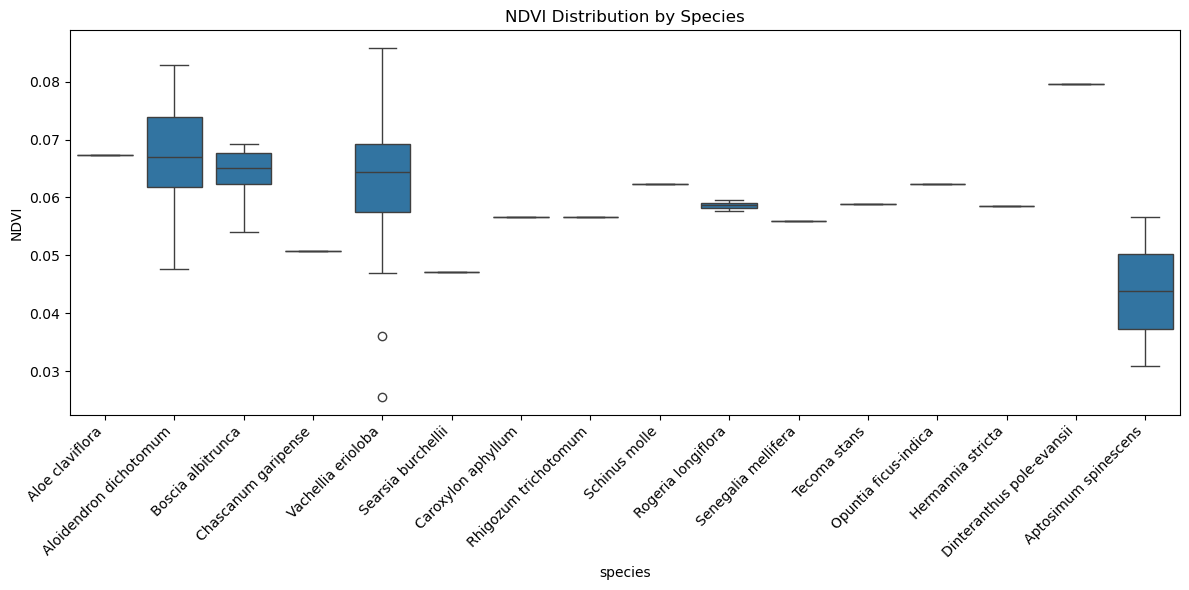

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

csv_data = pd.read_csv("/Users/kitlewers/GBIF_Remote_Sensing_Webinar_Notebooks/GoogleEarthEngine_Landsat/gbif_with_ndvi.csv")

plt.figure(figsize=(12, 6))
sns.boxplot(csv_data, x="species", y="NDVI")
plt.xticks(rotation=45, ha='right')
plt.title("NDVI Distribution by Species")
plt.tight_layout()
plt.show()


#### Cluster Species by Mean NDVI and Summarize Observations

To explore broader patterns in species’ habitat preferences, we perform an **unsupervised clustering analysis** based on the average NDVI values associated with each species. This helps identify groups of species that tend to occur in similar vegetation conditions.

Steps performed:

1. **Group the data by species** and calculate the **mean NDVI** for each species.
2. Apply **KMeans clustering** (`n_clusters=3`) to group species into clusters based on their NDVI means.
3. Create a **pivot table** summarizing:

   * The **mean NDVI** per species
   * The **standard deviation (NDVI variability)** across observations
   * The **number of GBIF occurrences** for each species
4. **Visualize the clustering** using a scatterplot, where each species is plotted by its NDVI and colored by its assigned cluster.

This analysis provides insight into:

* Which species tend to share similar vegetation environments
* How frequently each species was observed
* Potential groupings that could reflect ecological traits, such as preference for high or low productivity habitats

Clustering species based on remote sensing metrics like NDVI can support biodiversity monitoring, trait-based ecology, and habitat modeling.


,species,ndvi_mean,ndvi_std,occurrence_count
0,Aloe claviflora,0.067309,NaN,1
1,Aloidendron dichotomum,0.067347,0.008395,27
2,Aptosimum spinescens,0.043802,0.018226,2
3,Boscia albitrunca,0.063908,0.005591,6
4,Caroxylon aphyllum,0.056689,NaN,1
5,Chascanum garipense,0.050742,NaN,1
6,Dinteranthus pole-evansii,0.079529,NaN,1
7,Hermannia stricta,0.058508,NaN,1
8,Opuntia ficus-indica,0.062364,NaN,1
9,Rhigozum trichotomum,0.056689,NaN,1


[[0.06102227]
 [0.04722674]
 [0.07952859]]


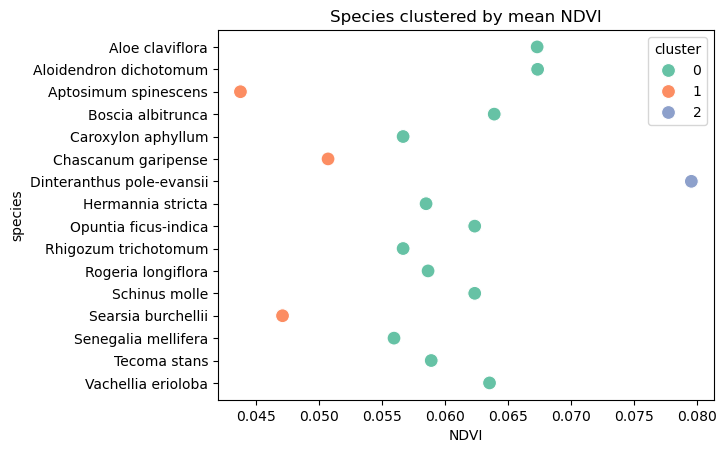

In [56]:
from sklearn.cluster import KMeans

species_means = csv_data.groupby("species")["NDVI"].mean().reset_index()
kmeans = KMeans(n_clusters=3)
species_means["cluster"] = kmeans.fit_predict(species_means[["NDVI"]])

pivot = csv_data.pivot_table(
    index='species',
    values='NDVI',
    aggfunc=['mean', 'std', 'count']
)

# Rename columns for clarity
pivot.columns = ['ndvi_mean', 'ndvi_std', 'occurrence_count']
pivot = pivot.reset_index()

display(pivot)

print(kmeans.cluster_centers_)

sns.scatterplot(data=species_means, x="NDVI", y="species", hue="cluster", palette="Set2", s=100)
plt.title("Species clustered by mean NDVI")
plt.show()
